# Robustness and Exploration of Variational and Machine Learning Approaches to Inverse Problems

## Imports and setup

In [1]:
%reload_ext autoreload
%autoreload 2

%env CUBLAS_WORKSPACE_CONFIG=:4096:8

from pathlib import Path
from typing import Callable, Literal, Optional, Tuple, Union, cast

import matplotlib.pyplot  as plt
import torch
import torch.backends.cudnn
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchopt
from tqdm.auto import tqdm

from gamm23.data import load_datasets
from gamm23.networks import UNet, Tiramisu, ItNet
from gamm23.utils import seed

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 16
})

torch.set_grad_enabled(False)
torch.set_default_dtype(torch.float64)

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


## Configuration

In [2]:
SEED = 314176
seed(SEED)
DEVICE = torch.device("cuda:0")
NUM_WORKERS = 0 #os.cpu_count()

NOISE_LEVEL = 0.03
BATCH_SIZE = 128
DATA_SIZE = 1024
MEASUREMENT_SIZE = 512

ADV_LR = 1e1
ADV_ITERATIONS = 1
ADV_EPSILON = 2e-1

B = 7

In [31]:
TIK_ALPHA_OPT = 1e-7
TIK_ALPHA_LARGE = 1e2

TV_SOLVER = lambda x: globals()["tv_admm"](x)
# SGD
#TV_LR = 3e-2
#TV_ALPHA = 1e1
#TV_ITERATIONS = 1000
# ADMM
TV_ITERATIONS = 2_200
TV_LAMBDA = 1e0
TV_ALPHA = 1e0
# PDHG 1
#TV_ALPHA = 1e-2
#TV_ITERATIONS = 50
#TV_TAU = 1e2
#TV_SIGMA = TV_TAU
# PDHG 2
#TV_ITERATIONS = 5000
#TV_TAU = 9e-4
#TV_SIGMA = TV_TAU
#TV_ALPHA = 1e1

In [4]:
UNET_WEIGHTS_PATH = Path("weights/unet/final.pth")
UNET_TIK_ALPHA = 0.01

TIRAMISU_WEIGHTS_PATH = Path("weights/tiramisu/final.pth")

ITNET_WEIGHTS_PATH = Path("weights/itnet/final.pth")
ITNET_TIK_ALPHA = 0.01
ITNET_INTERN_LR = 0.01
ITNET_INTERN_ITERATIONS = 8

## Operators

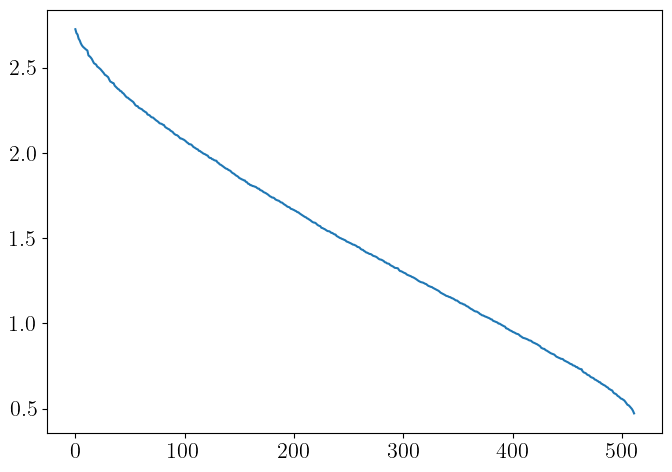

In [32]:
__A = torch.load(Path(".").parent.joinpath("src", "gamm23", "operators", "matrix.pth")).to(DEVICE).to(torch.get_default_dtype()).unsqueeze(0)
_U = torch.linalg.svd(__A[0].to("cpu"), full_matrices=True)[0].to(DEVICE)
__AI = __A@torch.tril(torch.ones((1,DATA_SIZE,DATA_SIZE), device=DEVICE))
__AITAIpIi = (__AI.mT@__AI + torch.eye(DATA_SIZE, device=DEVICE)).inverse()
__lAITAIpIi = ((TV_LAMBDA if "TV_LAMBDA" in globals().keys() else 1.0)*__AI.mT@__AI + torch.eye(DATA_SIZE, device=DEVICE)).inverse()
__D = torch.eye(DATA_SIZE, device=DEVICE)-torch.diag(torch.ones((DATA_SIZE-1), device=DEVICE), -1).unsqueeze(0)
__ATApaD2iAT_opt = (__A.mT@__A+TIK_ALPHA_OPT*__D.mT@__D).inverse()@__A.mT
__ATApaD2iAT_large = (__A.mT@__A+TIK_ALPHA_LARGE*__D.mT@__D).inverse()@__A.mT
__ATApaD2iAT_unet = (__A.mT@__A+UNET_TIK_ALPHA*__D.mT@__D).inverse()@__A.mT
__ATApaD2iAT_itnet = (__A.mT@__A+ITNET_TIK_ALPHA*__D.mT@__D).inverse()@__A.mT
D = lambda x: (__D@x.unsqueeze(-1))[...,0]
A = lambda x: (__A@x.unsqueeze(-1))[...,0]
A_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0]
AI = lambda x: (__A@x.cumsum(1).unsqueeze(-1))[...,0]
AI_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
AITAIpIi = lambda x: (__AITAIpIi@x.unsqueeze(-1))[...,0]
lAITAIpIi = lambda x: (__lAITAIpIi@x.unsqueeze(-1))[...,0]
A_Tik_opt = lambda x: (__ATApaD2iAT_opt@x.unsqueeze(-1))[...,0]
A_Tik_large = lambda x: (__ATApaD2iAT_large@x.unsqueeze(-1))[...,0]
A_Tik_unet = lambda x: (__ATApaD2iAT_unet@x.unsqueeze(-1))[...,0]
A_Tik_itnet = lambda x: (__ATApaD2iAT_itnet@x.unsqueeze(-1))[...,0]

plt.figure(figsize=(7,5))
plt.plot(torch.linalg.svd(__A[0].to("cpu"), full_matrices=True)[1].detach().numpy())
plt.tight_layout()
plt.show()

## Data generation

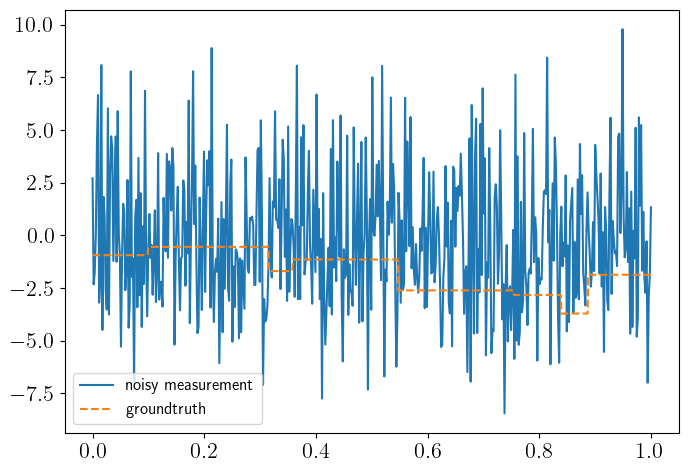

In [6]:
train_dataset, val_dataset, test_dataset = load_datasets(Path(".").parent.joinpath("src", "gamm23", "data", "noisy"))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=NUM_WORKERS, worker_init_fn=lambda _: seed(torch.initial_seed()))
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, worker_init_fn=lambda _: seed(torch.initial_seed()))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS, worker_init_fn=lambda _: seed(torch.initial_seed()))

noisy_measurement, groundtruth = train_dataset[0]
noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
plt.figure(figsize=(7,5))
plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[0]), noisy_measurement.detach().to("cpu").numpy(), label="noisy measurement")
plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[0]), groundtruth.detach().to("cpu").numpy(), "--", label="groundtruth")
plt.legend(prop={"size": 12})
plt.tight_layout()
plt.savefig("figures/data.pdf")
plt.show()

## Utilities

In [7]:
class TensorModule(nn.Module):
    def __init__(self, initial_value: Tensor) -> None:
        super().__init__()
        self.__tensor = torch.nn.parameter.Parameter(initial_value)
    
    @property
    def tensor(self) -> torch.Tensor:
        return self.__tensor

In [8]:
def project_ball(x: Tensor, epsilon: float, p: Optional[int] = None) -> Tensor:
    if p is None:
        return torch.clamp(x, -epsilon, epsilon)
    elif p == 2:
        return epsilon * x / torch.clamp(torch.pow(x, 2.0).sum(1, keepdim=True).sqrt(), epsilon)
    else:
        raise NotImplementedError()

In [16]:
def attack(noisy_measurement: Tensor, fwd: Callable[[Tensor], Tensor], type_: Union[Literal["pgd"],Literal["svd"]] = "pgd") -> Tuple[Tensor,Tensor]:
    original_reconstruction = fwd(noisy_measurement)
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    reconstruction = original_reconstruction.clone()
    for _ in range(ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = fwd(adversarial_measurement)
            loss = F.mse_loss(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + ADV_LR*torch.sign(cast(Tensor, adversarial_measurement.grad))
        adversarial_measurement = noisy_measurement + project_ball(adversarial_measurement-noisy_measurement, ADV_EPSILON)
        adversarial_measurement.requires_grad = True
    if type_ == "svd":
        delta = _U[:,511].unsqueeze(0)
        norm = lambda x: torch.pow(x, 2.0).sum(dim=1, keepdim=True).sqrt()
        adversarial_measurement = noisy_measurement+delta/norm(delta)*norm(adversarial_measurement-noisy_measurement)
    return adversarial_measurement, original_reconstruction

## Metrics

In [10]:
class Metrics:
    def __init__(self) -> None:
        super().__init__()
        self.__n = 0
        self.__has_adv = False
        self.__u_ugt_acc = 0.0
        self.__uadv_ugt_acc = 0.0
        self.__u_uadv_acc = 0.0
        self.__Au_f_acc = 0.0
        self.__Auadv_fadv_acc = 0.0
        self.__Au_Auadv_acc = 0.0
        self.__Du_Duadv_acc = 0.0
        self.__f_fadv_acc = 0.0

    def update(self,
        groundtruth: Tensor,
        noisy_measurement: Tensor,
        reconstruction: Tensor,
        adversarial_measurement: Optional[Tensor] = None,
        adversarial_reconstruction: Optional[Tensor] = None,
    ) -> None:
        self.__n += 1
        self.__u_ugt_acc += torch.pow(reconstruction-groundtruth, 2.0).sum()
        self.__Au_f_acc += torch.pow(A(reconstruction)-noisy_measurement, 2.0).sum()
        if adversarial_measurement is not None:
            self.__has_adv = True
            self.__uadv_ugt_acc += torch.pow(adversarial_reconstruction-groundtruth, 2.0).sum()
            self.__u_uadv_acc += torch.pow(reconstruction-adversarial_reconstruction, 2.0).sum()
            self.__Au_Auadv_acc += torch.pow(A(reconstruction)-A(adversarial_reconstruction), 2.0).sum()
            self.__Du_Duadv_acc += torch.pow(D(reconstruction)-D(adversarial_reconstruction), 2.0).sum()
            self.__Auadv_fadv_acc += torch.pow(A(adversarial_reconstruction)-adversarial_measurement, 2.0).sum()
            self.__f_fadv_acc += torch.pow(noisy_measurement-adversarial_measurement, 2.0).sum()

    def calculate(self) -> dict[str, float]:
        return {
            "$\\|\\hat{u}-u\\|^2$": self.__u_ugt_acc/self.__n,
            "$\\|A\\left(\\hat{u}\\right)-f\\|^2$": self.__Au_f_acc/self.__n,
            "$\\|\\hat{u}_{adv}-u\\|^2$": self.__uadv_ugt_acc/self.__n,
            "$\\|\\hat{u}-\\hat{u}_{adv}\\|^2$": self.__u_uadv_acc/self.__n,
            "$\\|A\\left(\\hat{u}_{adv}\\right)-f_{adv}\\|^2$": self.__Auadv_fadv_acc/self.__n,
            "$\\|A\\left(\\hat{u}\\right)-A\\left(\\hat{u}_{adv}\\right)\\|^2$": self.__Au_Auadv_acc/self.__n,
            "$\\|D\\left(\\hat{u}\\right)-D\\left(u_{adv}\\right)\\|^2$": self.__Du_Duadv_acc/self.__n,
            "$\\|f-f_{adv}\\|^2$": self.__f_fadv_acc/self.__n,
        }
    
    def __str__(self) -> str:
        return \
            f"|u-u_gt|^2:         {self.__u_ugt_acc/self.__n:11.5f}\n" + \
            f"|A(u)-f|^2:         {self.__Au_f_acc/self.__n:11.5f}\n" + (\
            f"|u_adv-u_gt|^2:     {self.__uadv_ugt_acc/self.__n:11.5f}\n" + \
            f"|u-u_adv|^2:        {self.__u_uadv_acc/self.__n:11.5f}\n" + \
            f"|A(u_adv)-f_adv|^2: {self.__Auadv_fadv_acc/self.__n:11.5f}\n" + \
            f"|A(u)-A(u_adv)|^2:  {self.__Au_Auadv_acc/self.__n:11.5f}\n" + \
            f"|D(u)-D(u_adv)|^2:  {self.__Du_Duadv_acc/self.__n:11.5f}\n" + \
            f"|f-f_adv|^2:        {self.__f_fadv_acc/self.__n:11.5f}" if self.__has_adv else "")

## Algorithms

### Tikhonov

#### Optimal alpha

  0%|          | 0/16 [00:00<?, ?it/s]

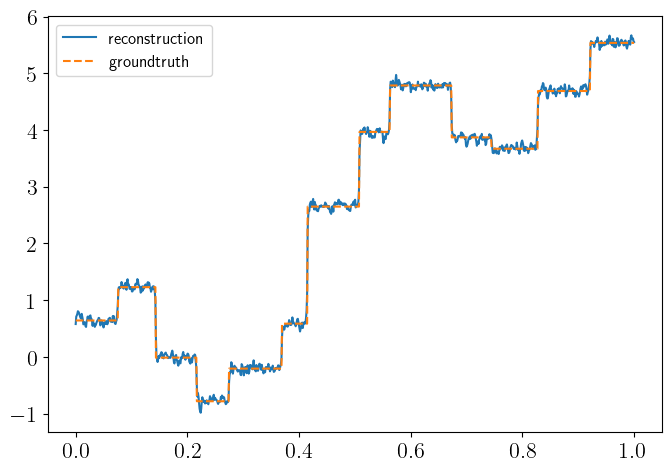

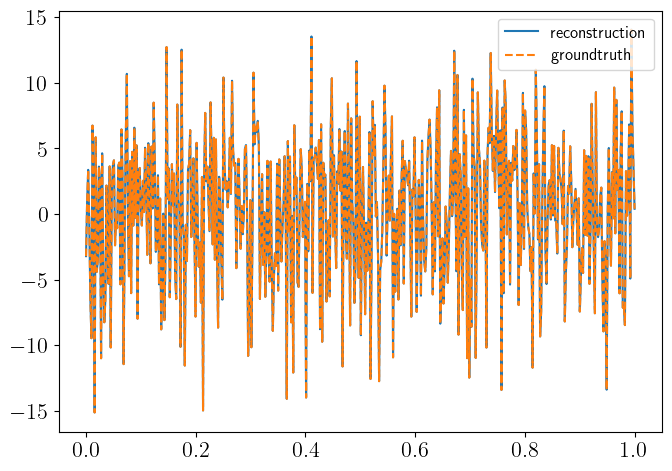

|u-u_gt|^2:           562.15895
|A(u)-f|^2:             0.00000



In [11]:
metrics = Metrics()
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction = A_Tik_opt(noisy_measurement)
    metrics.update(groundtruth, noisy_measurement, reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/tik.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

  0%|          | 0/16 [00:00<?, ?it/s]

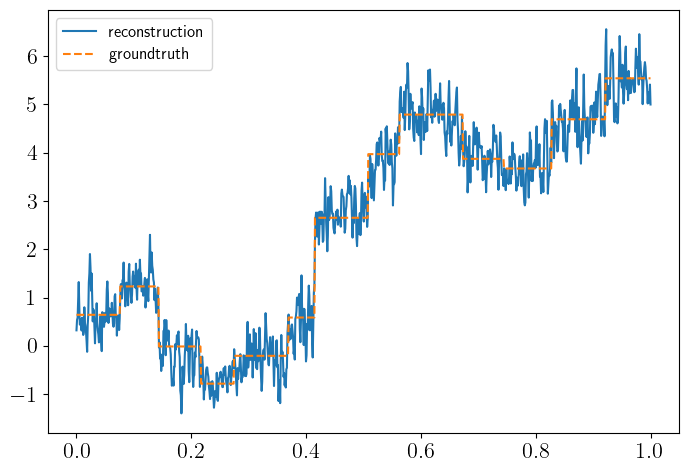

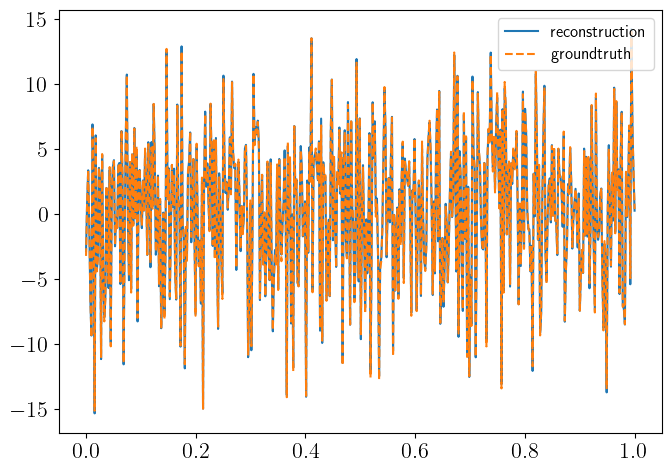

|u-u_gt|^2:           562.15895
|A(u)-f|^2:             0.00000
|u_adv-u_gt|^2:     20016.45761
|u-u_adv|^2:        19457.43780
|A(u_adv)-f_adv|^2:     0.00000
|A(u)-A(u_adv)|^2:   2621.43702
|D(u)-D(u_adv)|^2:  14891.24428
|f-f_adv|^2:         2621.44000


In [24]:
metrics = Metrics()
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    adversarial_measurement, original_reconstruction = attack(noisy_measurement, A_Tik_opt)
    adversarial_reconstruction = A_Tik_opt(adversarial_measurement)
    metrics.update(groundtruth, noisy_measurement, original_reconstruction, adversarial_measurement, adversarial_reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, adversarial_reconstruction.shape[1]), adversarial_reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/tik_adv.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(adversarial_reconstruction).shape[1]), A(adversarial_reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

#### Large alpha

  0%|          | 0/16 [00:00<?, ?it/s]

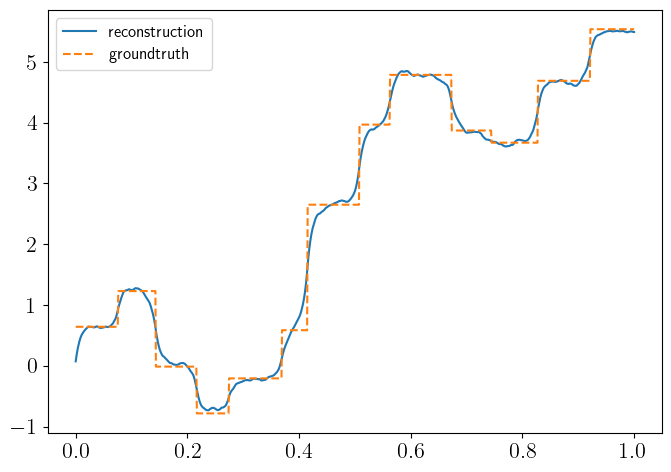

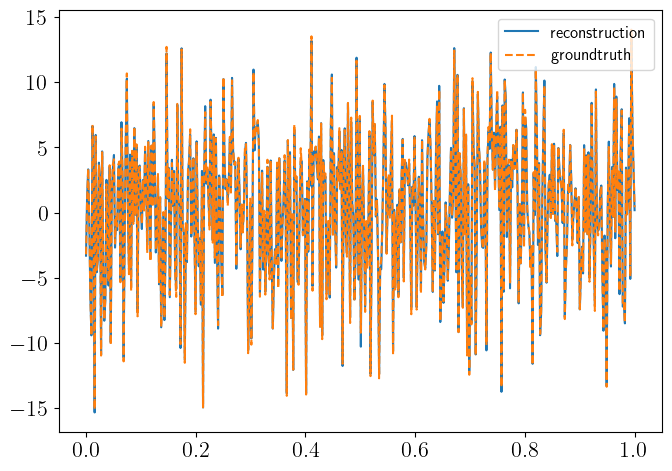

|u-u_gt|^2:          3948.60093
|A(u)-f|^2:          4023.99304



In [12]:
metrics = Metrics()
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction = A_Tik_large(noisy_measurement)
    metrics.update(groundtruth, noisy_measurement, reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/tik_large.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

  0%|          | 0/16 [00:00<?, ?it/s]

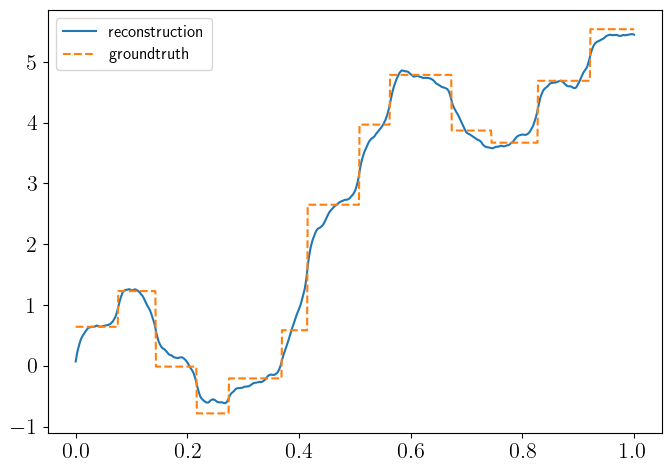

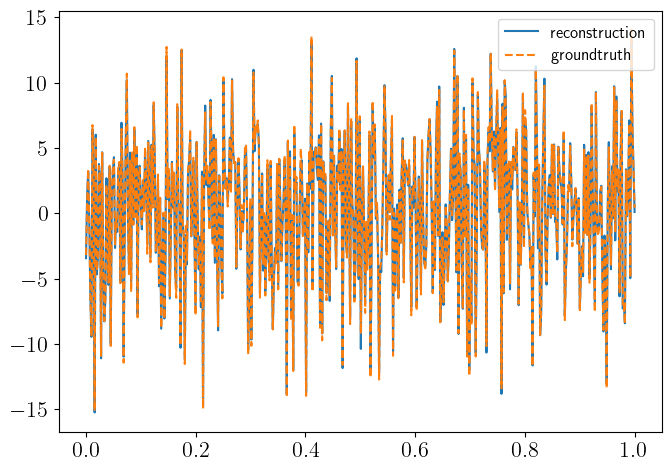

|u-u_gt|^2:          3948.60093
|A(u)-f|^2:          4023.99304
|u_adv-u_gt|^2:      6585.65000
|u-u_adv|^2:          834.05622
|A(u_adv)-f_adv|^2:  3549.66271
|A(u)-A(u_adv)|^2:    884.03794
|D(u)-D(u_adv)|^2:      3.25334
|f-f_adv|^2:         2621.44000


In [42]:
metrics = Metrics()
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    adversarial_measurement, original_reconstruction = attack(noisy_measurement, A_Tik_large, "pgd")
    adversarial_reconstruction = A_Tik_large(adversarial_measurement)
    metrics.update(groundtruth, noisy_measurement, original_reconstruction, adversarial_measurement, adversarial_reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, adversarial_reconstruction.shape[1]), adversarial_reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/tik_large_adv.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(adversarial_reconstruction).shape[1]), A(adversarial_reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

#### Upper bound

  0%|          | 0/16 [00:00<?, ?it/s]

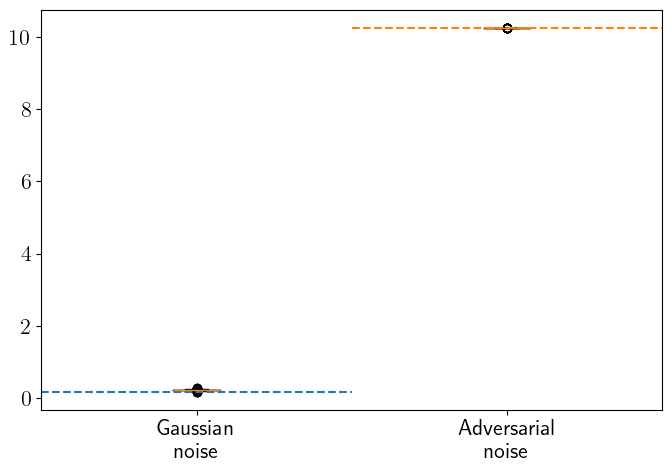

In [33]:
values_noise = []
values_adv = []
diffs_noise = []
diffs_adv = []
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    adversarial_measurement, _ = attack(noisy_measurement, A_Tik_opt)
    noisy_measurement2 = A(groundtruth)+NOISE_LEVEL*torch.randn_like(A(groundtruth))
    reconstruction = A_Tik_opt(noisy_measurement)
    reconstruction2 = A_Tik_opt(noisy_measurement2)
    reconstruction_adv = A_Tik_opt(adversarial_measurement)
    value_noise = TIK_ALPHA_OPT*torch.pow(D(reconstruction)-D(reconstruction2), 2.0).sum(dim=1) + 0.5*torch.pow(A(reconstruction)-A(reconstruction2), 2.0).sum(dim=1)
    diff_noise = 0.5 * torch.pow(noisy_measurement-noisy_measurement2, 2.0).sum(dim=1)
    value_adv = TIK_ALPHA_OPT*torch.pow(D(reconstruction)-D(reconstruction_adv), 2.0).sum(dim=1) + 0.5*torch.pow(A(reconstruction)-A(reconstruction_adv), 2.0).sum(dim=1)
    diff_adv = 0.5 * torch.pow(noisy_measurement-adversarial_measurement, 2.0).sum(dim=1)
    values_noise.extend(value_noise.tolist())
    diffs_noise.extend(diff_noise.tolist())
    values_adv.extend(value_adv.tolist())
    diffs_adv.extend(diff_adv.tolist())

plt.figure(figsize=(7,5))
plt.boxplot(torch.tensor(values_noise).flatten(), positions=[0.5])
plt.boxplot(torch.tensor(values_adv).flatten(), positions=[1.5])
plt.xticks([0.5, 1.5], ["Gaussian\nnoise", "Adversarial\nnoise"])
plt.plot(torch.linspace(0.0, 1.0, 10), torch.full((10,), torch.tensor(diffs_noise).min().item()), "--")
plt.plot(torch.linspace(1.0, 2.0, 10), torch.full((10,), torch.tensor(diffs_adv).min().item()), "--")
plt.tight_layout()
plt.savefig("figures/bound_tik.pdf")
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

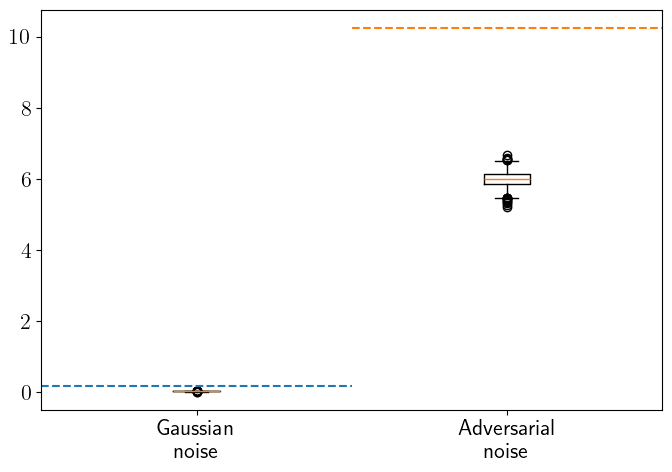

In [35]:
values_noise = []
values_adv = []
diffs_noise = []
diffs_adv = []
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction = A_Tik_large(noisy_measurement)
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    for _ in range(ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = A_Tik_large(adversarial_measurement)
            loss = F.mse_loss(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + ADV_LR*torch.sign(adversarial_measurement.grad)
        adversarial_measurement = noisy_measurement + project_ball(adversarial_measurement-noisy_measurement, ADV_EPSILON)
        adversarial_measurement.requires_grad = True
    noisy_measurement2 = A(groundtruth)+NOISE_LEVEL*torch.randn_like(A(groundtruth))
    reconstruction2 = A_Tik_large(noisy_measurement2)
    reconstruction = A_Tik_large(noisy_measurement)
    reconstruction_adv = A_Tik_large(adversarial_measurement)
    value_noise = TIK_ALPHA_LARGE*torch.pow(D(reconstruction)-D(reconstruction2), 2.0).sum(dim=1) + 0.5*torch.pow(A(reconstruction)-A(reconstruction2), 2.0).sum(dim=1)
    diff_noise = 0.5 * torch.pow(noisy_measurement-noisy_measurement2, 2.0).sum(dim=1)
    value_adv = TIK_ALPHA_LARGE*torch.pow(D(reconstruction)-D(reconstruction_adv), 2.0).sum(dim=1) + 0.5*torch.pow(A(reconstruction)-A(reconstruction_adv), 2.0).sum(dim=1)
    diff_adv = 0.5 * torch.pow(noisy_measurement-adversarial_measurement, 2.0).sum(dim=1)
    values_noise.extend(value_noise.tolist())
    diffs_noise.extend(diff_noise.tolist())
    values_adv.extend(value_adv.tolist())
    diffs_adv.extend(diff_adv.tolist())

plt.figure(figsize=(7,5))
plt.boxplot(torch.tensor(values_noise).flatten(), positions=[0.5])
plt.boxplot(torch.tensor(values_adv).flatten(), positions=[1.5])
plt.xticks([0.5, 1.5], ["Gaussian\nnoise", "Adversarial\nnoise"])
plt.plot(torch.linspace(0.0, 1.0, 10), torch.full((10,), torch.tensor(diffs_noise).min().item()), "--")
plt.plot(torch.linspace(1.0, 2.0, 10), torch.full((10,), torch.tensor(diffs_adv).min().item()), "--")
plt.tight_layout()
plt.savefig("figures/bound_tik_large.pdf")
plt.show()

### TV-Regularized energy minimization

#### Solvers

##### SGD

In [16]:
def tv_gd(noisy_measurement: Tensor) -> Tuple[Tensor,Tensor]:
    reconstruction = TensorModule(torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE))
    optimizer = torchopt.MetaAdam(reconstruction, lr=TV_LR)
    loss = torch.zeros((1),)
    with torch.enable_grad():
        for _ in range(TV_ITERATIONS):
            loss = F.mse_loss(A(reconstruction.tensor), noisy_measurement) + \
                   TV_ALPHA*F.conv1d(reconstruction.tensor.unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1).abs().mean()
            optimizer.step(loss)
    return reconstruction.tensor, cast(Tensor, None)

##### ADMM

$$
\argmin_u \frac{1}{2}\|Au-f\|_2^2 + \alpha\|u\|_1 = \argmin_u G(u) + F(u)\\
G(u) = \frac{1}{2}\|Au-f\|_2^2\\
%\operatorname{prox}_{\lambda G}(u) = (A^TA+I)^{-1}(\frac{u+A^Tf}{\lambda})\\
\operatorname{prox}_{\lambda G}(u) = (\lambda A^TA+I)^{-1}(u+\lambda A^Tf)\\
F(u) = \alpha\|u\|_1\\
\operatorname{prox}_{\lambda F}(u) = \operatorname{sign}(u)\max(|u|-\lambda\alpha,0)
$$

In [37]:
def tv_admm(noisy_measurement: Tensor) -> Tuple[Tensor,Tensor]:
    prox_G = lambda u: lAITAIpIi(u+TV_LAMBDA*AI_T(noisy_measurement))
    prox_F = lambda u: u.sign()*torch.clamp(u.abs()-TV_LAMBDA*TV_ALPHA, 0.0)
    x = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    y = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    z = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    for _ in range(TV_ITERATIONS):
        x = prox_F(y-z)
        y = prox_G(x+z)
        z = z+x-y
    x = x.cumsum(1)
    subgradient = -z/(TV_ALPHA*TV_LAMBDA)
    subgradient = F.conv_transpose1d(subgradient.unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1)[:,0]
    subgradient = torch.clamp(subgradient, -1.0, 1.0)
    return x, subgradient

##### PDHG - Version 1

$$
\argmin_u \frac{1}{2}\|Au-f\|_2^2 + \alpha\|u\|_1 = \argmin_u G(u) + F(Ku)\\

G(u) = \frac{1}{2}\|Au-f\|_2^2\\
K = I\\
F(u) = \alpha\|u\|_1\\
\begin{aligned}
F^*(u^*) &= \max_u \langle u,u^*\rangle - \alpha\|u\|_1 \\
         &= \max_u \langle u,u^*\rangle - \alpha\max_{p,\|p\|_\infty\le 1} \langle u, p\rangle\\
         &= \max_u \langle u,u^*\rangle + \alpha\min_{p,\|p\|_\infty\le 1} -\langle u, p\rangle\\
         &= \max_u \min_{p,\|p\|_\infty\le 1} \langle u,u^*-\alpha p\rangle\\
         &= \min_{p,\|p\|_\infty\le 1} \max_u \langle u,u^*-\alpha p\rangle\\
         &= \min_{p,\|p\|_\infty\le 1} \begin{cases}0&\text{if }u^* = \alpha p\\\infty&\text{else}\end{cases}\\
         &= \begin{cases}0&\text{if }\|u^*\|_\infty\le \alpha\\\infty&\text{else}\end{cases}\\
         &= \mathcal{X}_{B_\infty(0,\alpha)}(u^*)\\
\end{aligned}
$$

$$
G(u) = \frac{1}{2}\|Au-f\|_2^2\\
\begin{aligned}
\operatorname{prox}_{\tau G}(u) &= \argmin_z \tau\frac{1}{2}\|Az-f\|_2^2+\frac{1}{2}\|z-u\|_2^2\\
                                &= (A^TA+I)^{-1}\left(\frac{u}{\tau}+A^Tf\right)\\
\end{aligned}
$$
<br/><br/>
$$
F^*(u^*) = \mathcal{X}_{B_\infty(0,\alpha)}(u^*)\\
\begin{aligned}
\operatorname{prox}_{\sigma F}(u^*) &= \argmin_z \sigma\mathcal{X}_{B_\infty(0,\alpha)}(z)+\frac{1}{2}\|z-u^*\|_2^2\\
                                    &= \argmin_{z,\|z\|_\infty\le\alpha} \frac{1}{2}\|z-u^*\|_2^2\\
                                    &= \mathcal{P}_{B_\infty(0,\alpha)}(u^*)\\
\end{aligned}
$$

In [18]:
def tv_pdhg1(noisy_measurement: Tensor) -> Tuple[Tensor,Tensor]:
    prox_G = lambda u: AITAIpIi(u/TV_TAU+AI_T(noisy_measurement))
    prox_F_star = lambda u_star: torch.clamp(u_star, -TV_ALPHA, TV_ALPHA)
    K = AI
    K_T = AI_T
    x = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    y = torch.zeros((noisy_measurement.shape[0], MEASUREMENT_SIZE), device=DEVICE)
    x_bar = torch.zeros_like(x)
    for _ in range(TV_ITERATIONS):
        x_old = x
        y = prox_F_star(y+TV_SIGMA*K(x_bar))
        x = prox_G(x-TV_TAU*K_T(y))
        x_bar = 2.0*x-x_old
    x = x.cumsum(1)
    return x, cast(Tensor, None)

##### PDHG - Version 2

$$
\argmin_u \frac{1}{2}\|Au-f\|_2^2 + \alpha\|u\|_1 = \argmin_u G(u) + F(Ku)\\

G(u) = 0\\
K = \begin{pmatrix}A\\I\end{pmatrix}\\
F(u) = \frac{1}{2}\|u_1-f\|_2^2+\alpha\|u_2\|_1\\
\begin{aligned}
F^*(u^*) &= \begin{pmatrix}\max\limits_{u_1}\langle u_1, u_1^*\rangle - \frac{1}{2}\|u_1-f\|_2^2\\\max\limits_{u_2}\langle u_2, u_2^*\rangle - \alpha\|u_2\|_1\end{pmatrix}\\
         &= \begin{pmatrix}\frac{1}{2}\|u_1^*\|_2^2 + \langle f, u_1^*\rangle\\\mathcal{X}_{B_\infty(0,\alpha)}(u_2^*)\end{pmatrix}
\end{aligned}
$$

$$
G(u) = 0\\
\begin{aligned}
\operatorname{prox}_{\tau G}(u) &= \argmin_z \frac{1}{2}\|z-u\|_2^2\\
                                &= u\\
\end{aligned}
$$
<br/><br/>
$$
F^*(u^*) = \begin{pmatrix}\frac{1}{2}\|u_1^*\|_2^2 + \langle f, u_1^*\rangle\\\mathcal{X}_{B_\infty(0,\alpha)}(u_2^*)\end{pmatrix}\\
\begin{aligned}
\operatorname{prox}_{\sigma F}(u^*) &= \begin{pmatrix}\argmin\limits_{z} \sigma\frac{1}{2}\|z\|_2^2 + \sigma\langle f, z\rangle+\frac{1}{2}\|z-u^*_1\|_2^2\\
                                                      \argmin\limits_{z} \sigma\mathcal{X}_{B_\infty(0,\alpha)}(z)+\frac{1}{2}\|z-u^*_2\|_2^2\end{pmatrix}\\
                                    &= \begin{pmatrix}\frac{u^*_1-\sigma f}{1+\sigma}\\
                                                      \mathcal{P}_{B_\infty(0,\alpha)}(u_2^*)\end{pmatrix}
\end{aligned}
$$

In [19]:
def tv_pdhg2(noisy_measurement: Tensor) -> Tuple[Tensor,Tensor]:
    prox_G = lambda u: u
    prox_F_star = lambda u_star: torch.cat([
        (u_star[:,:MEASUREMENT_SIZE]-TV_SIGMA*noisy_measurement)/(1.0+TV_SIGMA), 
        torch.clamp(u_star[:,MEASUREMENT_SIZE:], -TV_ALPHA, TV_ALPHA)
    ], dim=1)
    K = lambda u: torch.cat([
        AI(u),
        #F.conv1d(u.unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1)[:,0],
        u
    ], dim=1)
    K_T = lambda u_star:\
        AI_T(u_star[:,:MEASUREMENT_SIZE])+\
        u_star[:,MEASUREMENT_SIZE:]
        #F.conv_transpose1d(u_star[:,s1:].unsqueeze(1), torch.tensor([[[-1.0,1.0,0.0]]], device=DEVICE), padding=1)[:,0]
    x = torch.zeros((noisy_measurement.shape[0], DATA_SIZE), device=DEVICE)
    y = torch.zeros((noisy_measurement.shape[0], MEASUREMENT_SIZE+DATA_SIZE), device=DEVICE)
    x_bar = torch.zeros_like(x)
    for _ in range(TV_ITERATIONS):
        x_old = x
        y = prox_F_star(y+TV_SIGMA*K(x_bar))
        x = prox_G(x-TV_TAU*K_T(y))
        x_bar = 2.0*x-x_old
    x = x.cumsum(1)
    return x, cast(Tensor, None)

#### Upper bound

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_250500/2022097596.py:15: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  AI_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
/tmp/ipykernel_250500/1607159626.py:11: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  x = x.cumsum(1)
/home/alexander/anaconda3/envs/GAMM/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: cumsum_cuda_kernel do

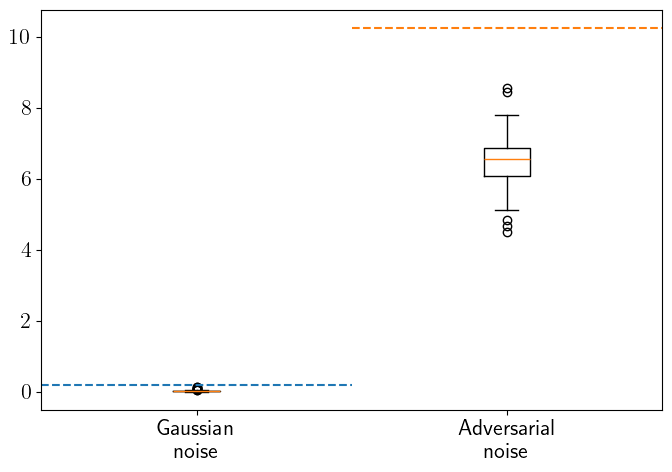

In [38]:
values_noise = []
values_adv = []
diffs_noise = []
diffs_adv = []
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction = TV_SOLVER(noisy_measurement)[0]
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    for _ in range(ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = TV_SOLVER(adversarial_measurement)[0]
            loss = F.mse_loss(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + ADV_LR*torch.sign(adversarial_measurement.grad)
        adversarial_measurement = noisy_measurement + project_ball(adversarial_measurement-noisy_measurement, ADV_EPSILON)
        adversarial_measurement.requires_grad = True
    noisy_measurement2 = A(groundtruth)+NOISE_LEVEL*torch.randn_like(A(groundtruth))
    reconstruction2, subgradient2 = TV_SOLVER(noisy_measurement2)
    reconstruction, subgradient = TV_SOLVER(noisy_measurement)
    reconstruction_adv, subgradient_adv = TV_SOLVER(adversarial_measurement)
    value_noise = TV_ALPHA*torch.sum((subgradient-subgradient2)*(reconstruction-reconstruction2), dim=1) + 0.5*torch.pow(A(reconstruction)-A(reconstruction2), 2.0).sum(dim=1)
    diff_noise = 0.5 * torch.pow(noisy_measurement-noisy_measurement2, 2.0).sum(dim=1)
    value_adv = TV_ALPHA*torch.sum((subgradient-subgradient_adv)*(reconstruction-reconstruction_adv), dim=1) + 0.5*torch.pow(A(reconstruction)-A(reconstruction_adv), 2.0).sum(dim=1)
    diff_adv = 0.5 * torch.pow(noisy_measurement-adversarial_measurement, 2.0).sum(dim=1)
    values_noise.extend(value_noise.tolist())
    diffs_noise.extend(diff_noise.tolist())
    values_adv.extend(value_adv.tolist())
    diffs_adv.extend(diff_adv.tolist())
    break

plt.figure(figsize=(7,5))
plt.boxplot(torch.tensor(values_noise).flatten(), positions=[0.5])
plt.boxplot(torch.tensor(values_adv).flatten(), positions=[1.5])
plt.xticks([0.5, 1.5], ["Gaussian\nnoise", "Adversarial\nnoise"])
plt.plot(torch.linspace(0.0, 1.0, 10), torch.full((10,), torch.tensor(diffs_noise).min().item()), "--")
plt.plot(torch.linspace(1.0, 2.0, 10), torch.full((10,), torch.tensor(diffs_adv).min().item()), "--")
plt.tight_layout()
plt.savefig("figures/bound_tv.pdf")
plt.show()

#### Reconstructions

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_3722514/970687704.py:14: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  AI_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
/tmp/ipykernel_3722514/1607159626.py:11: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  x = x.cumsum(1)


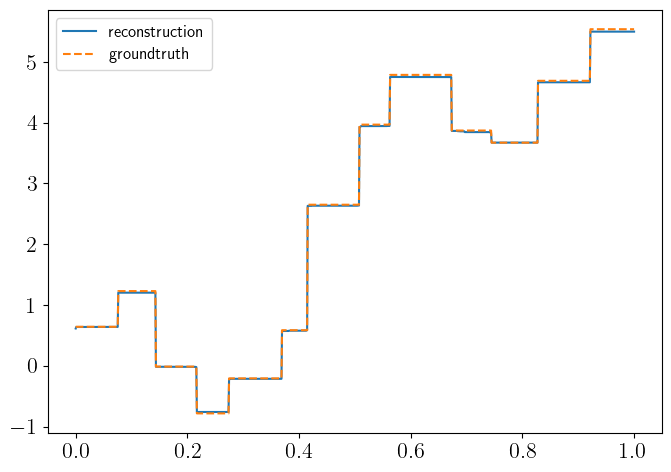

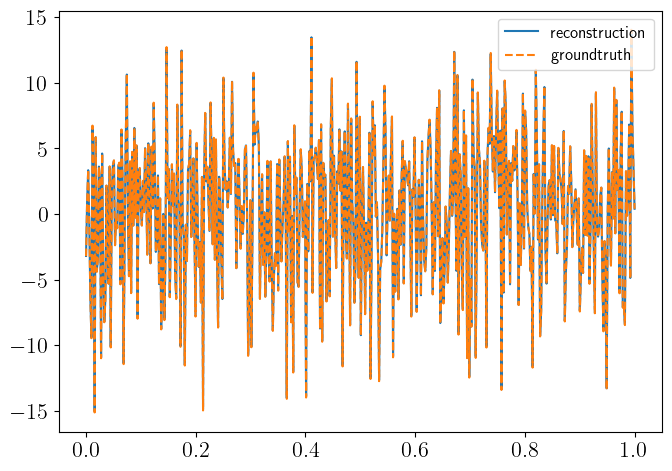

|u-u_gt|^2:            84.46595
|A(u)-f|^2:           107.09331



In [21]:
metrics = Metrics()
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction, subgradient = TV_SOLVER(noisy_measurement)
    metrics.update(groundtruth, noisy_measurement, reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/tv.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_250500/2022097596.py:15: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  AI_T = lambda x: (__A.mT@x.unsqueeze(-1))[...,0].flip(1).cumsum(1).flip(1)
/tmp/ipykernel_250500/1607159626.py:11: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  x = x.cumsum(1)


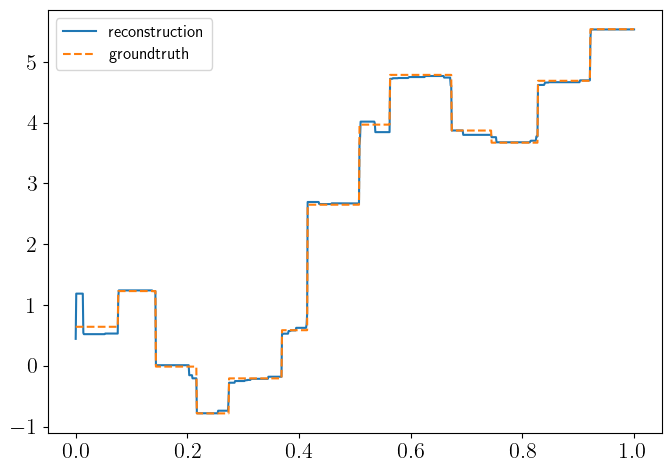

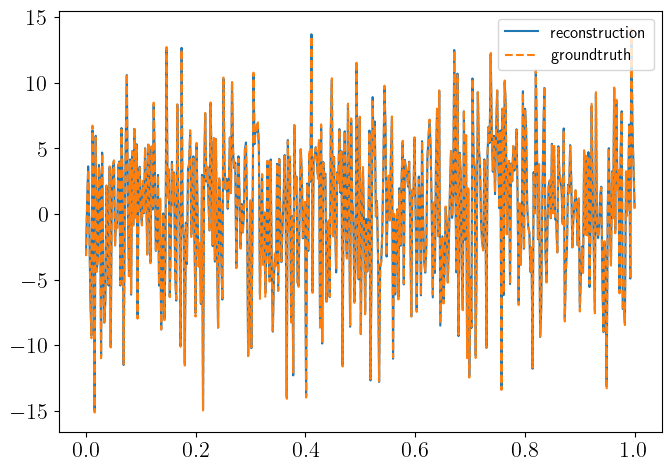

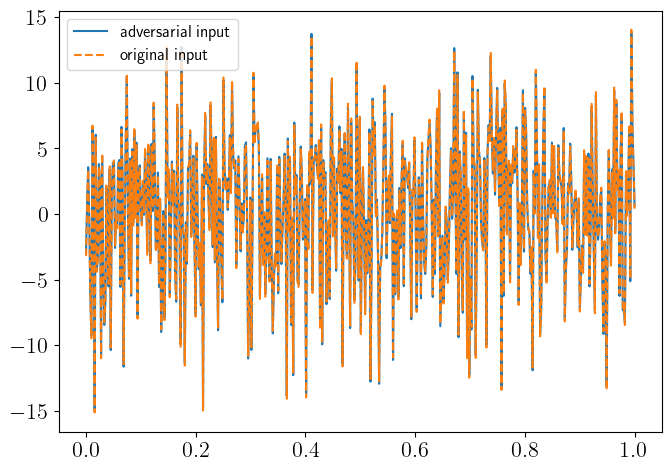

|u-u_gt|^2:            84.46595
|A(u)-f|^2:           107.09331
|u_adv-u_gt|^2:      1476.96570
|u-u_adv|^2:         1188.24561
|A(u_adv)-f_adv|^2:   981.83235
|A(u)-A(u_adv)|^2:   1323.41539
|D(u)-D(u_adv)|^2:    207.42842
|f-f_adv|^2:         2621.44000


In [41]:
metrics = Metrics()
for i, (noisy_measurement, groundtruth) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    adversarial_measurement, original_reconstruction = attack(noisy_measurement, lambda x: TV_SOLVER(x)[0])
    #original_reconstruction = TV_SOLVER(noisy_measurement)[0]
    #adversarial_measurement = noisy_measurement.clone()
    #adversarial_measurement.requires_grad = True
    #reconstruction = original_reconstruction.clone()
    #for _ in range(ADV_ITERATIONS):
    #    with torch.enable_grad():
    #        reconstruction = TV_SOLVER(adversarial_measurement)[0]
    #        loss = F.mse_loss(reconstruction, groundtruth)
    #        loss.backward()
    #    adversarial_measurement = adversarial_measurement + ADV_LR*torch.sign(adversarial_measurement.grad)
    #    adversarial_measurement = noisy_measurement + project_ball(adversarial_measurement-noisy_measurement, ADV_EPSILON)
    #    adversarial_measurement.requires_grad = True
    adversarial_reconstruction = TV_SOLVER(adversarial_measurement)[0]
    metrics.update(groundtruth, noisy_measurement, original_reconstruction, adversarial_measurement, adversarial_reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, adversarial_reconstruction.shape[1]), adversarial_reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/tv_adv.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(adversarial_reconstruction).shape[1]), A(adversarial_reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[B].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[B].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

### Post-processing U-Net

In [23]:
unet = UNet(1, 1, A_Tik_unet, dims=1).to(DEVICE)
_ = unet.load_state_dict(torch.load(str(UNET_WEIGHTS_PATH.resolve()))["network"])

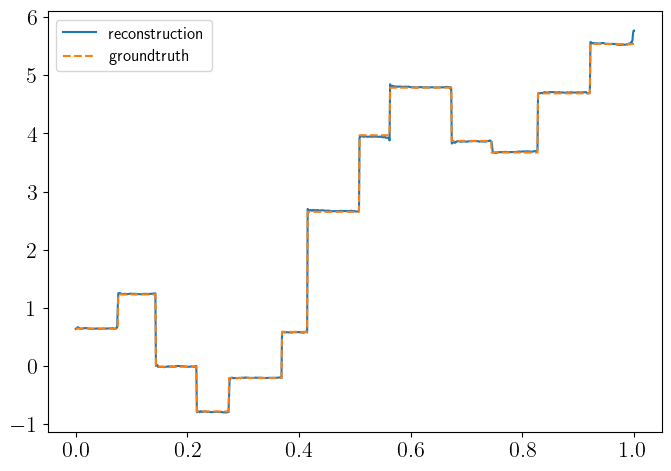

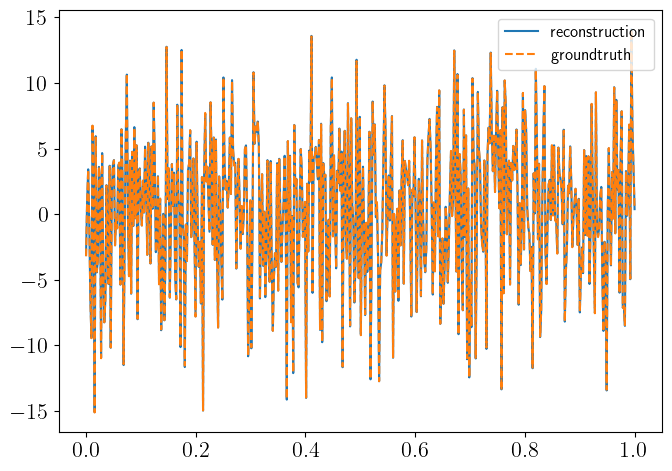

|u-u_gt|^2:            48.92460
|A(u)-f|^2:            58.25257



In [24]:
metrics = Metrics()
unet.eval()
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
    metrics.update(groundtruth, noisy_measurement, reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/unet.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

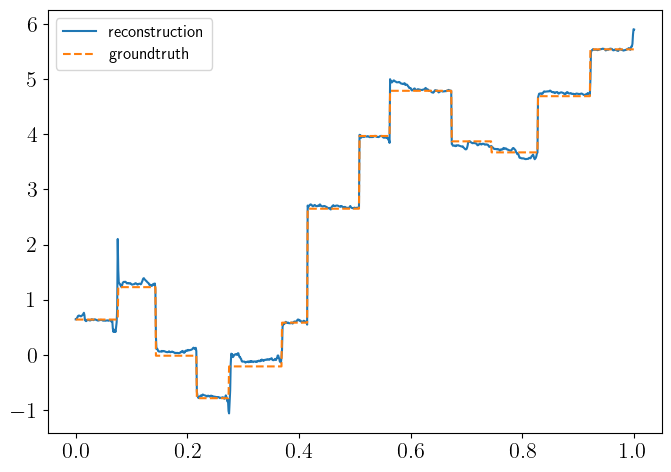

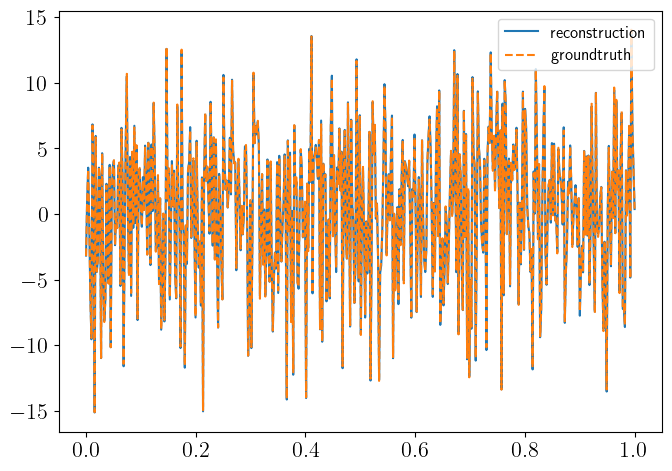

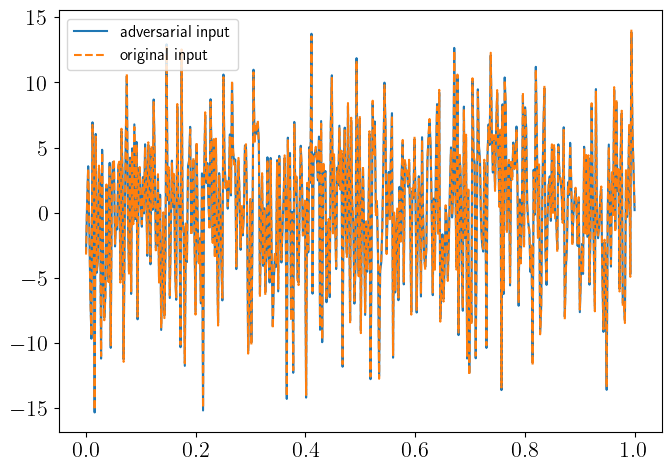

|u-u_gt|^2:            48.92460
|A(u)-f|^2:            58.25257
|u_adv-u_gt|^2:      3264.69136
|u-u_adv|^2:         2848.82806
|A(u_adv)-f_adv|^2:  3365.64669
|A(u)-A(u_adv)|^2:   2743.66759
|D(u)-D(u_adv)|^2:    492.60453
|f-f_adv|^2:         2621.44000


In [25]:
metrics = Metrics()
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    original_reconstruction = unet(noisy_measurement.unsqueeze(1))[:,0]
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    reconstruction = original_reconstruction.clone()
    for _ in range(ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = unet(adversarial_measurement.unsqueeze(1))[:,0]
            loss = F.mse_loss(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + ADV_LR*torch.sign(adversarial_measurement.grad)
        adversarial_measurement = noisy_measurement + project_ball(adversarial_measurement-noisy_measurement, ADV_EPSILON)
        adversarial_measurement.requires_grad = True
    adversarial_reconstruction = unet(adversarial_measurement.unsqueeze(1))[:,0]
    metrics.update(groundtruth, noisy_measurement, original_reconstruction, adversarial_measurement, adversarial_reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, adversarial_reconstruction.shape[1]), adversarial_reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/unet_adv.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(adversarial_reconstruction).shape[1]), A(adversarial_reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[B].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[B].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

### End-2-End Tiramisu

In [26]:
tiramisu = Tiramisu(1, 1, MEASUREMENT_SIZE, DATA_SIZE, dims=1).to(DEVICE)
_ = tiramisu.load_state_dict(torch.load(str(TIRAMISU_WEIGHTS_PATH.resolve()))["network"])

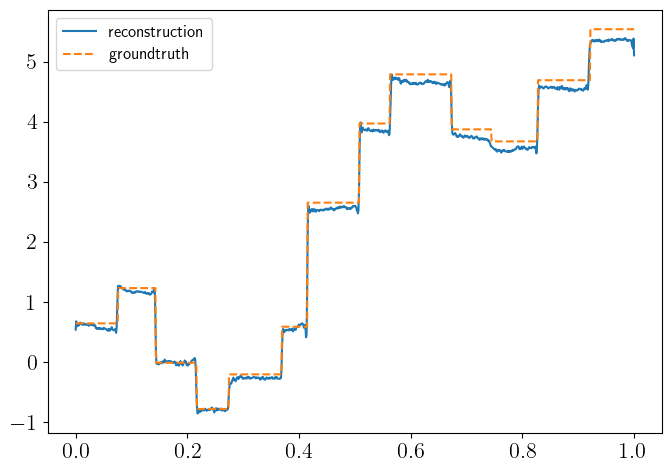

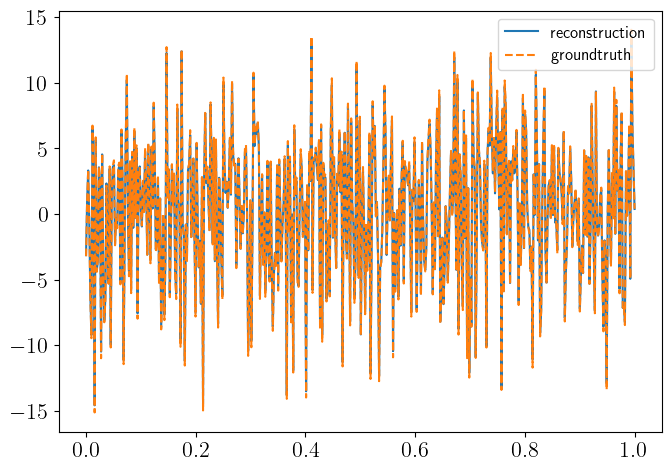

|u-u_gt|^2:          1110.99601
|A(u)-f|^2:          1366.52366



In [27]:
metrics = Metrics()
tiramisu.eval()
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction = tiramisu(noisy_measurement.unsqueeze(1))[:,0]
    metrics.update(groundtruth, noisy_measurement, reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/tiramisu.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

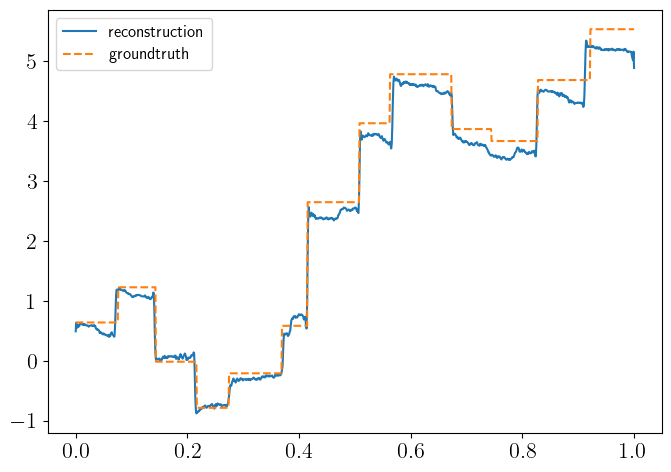

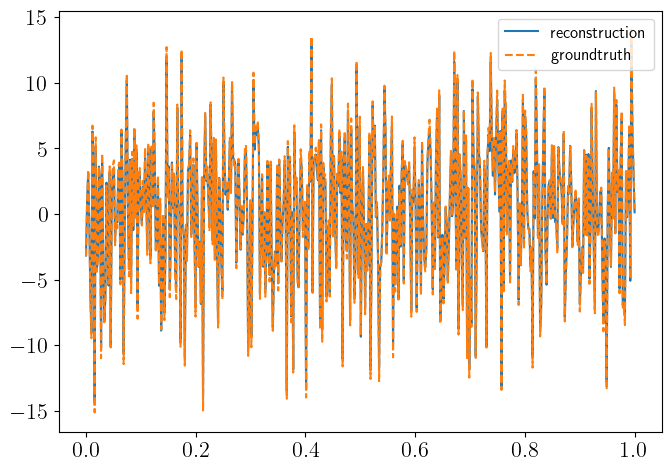

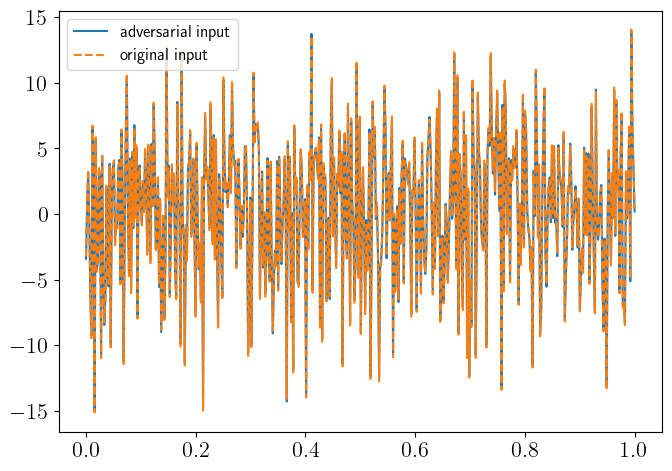

|u-u_gt|^2:          1110.99601
|A(u)-f|^2:          1366.52366
|u_adv-u_gt|^2:      6012.05675
|u-u_adv|^2:         3296.41574
|A(u_adv)-f_adv|^2:  5301.37044
|A(u)-A(u_adv)|^2:   3641.13597
|D(u)-D(u_adv)|^2:    700.50595
|f-f_adv|^2:         2621.44000


In [28]:
metrics = Metrics()
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    original_reconstruction = tiramisu(noisy_measurement.unsqueeze(1))[:,0]
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    reconstruction = original_reconstruction.clone()
    for _ in range(ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = tiramisu(adversarial_measurement.unsqueeze(1))[:,0]
            loss = F.mse_loss(reconstruction, groundtruth)
            loss.backward()
        torch.cuda.empty_cache()
        adversarial_measurement = adversarial_measurement + ADV_LR*torch.sign(adversarial_measurement.grad)
        adversarial_measurement = noisy_measurement + project_ball(adversarial_measurement-noisy_measurement, ADV_EPSILON)
        adversarial_measurement.requires_grad = True
    adversarial_reconstruction = tiramisu(adversarial_measurement.unsqueeze(1))[:,0]
    metrics.update(groundtruth, noisy_measurement, original_reconstruction, adversarial_measurement, adversarial_reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, adversarial_reconstruction.shape[1]), adversarial_reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/tiramisu_adv.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(adversarial_reconstruction).shape[1]), A(adversarial_reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[B].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[B].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

### Iterative ItNet

In [29]:
itnet = ItNet(1, 1, A, A_T, A_Tik_itnet, ITNET_INTERN_ITERATIONS, ITNET_INTERN_LR, dims=1).to(DEVICE)
_ = itnet.load_state_dict(torch.load(str(ITNET_WEIGHTS_PATH.resolve()))["network"])

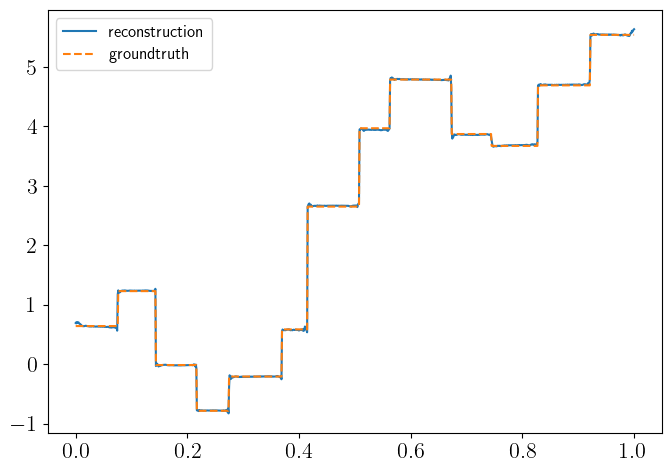

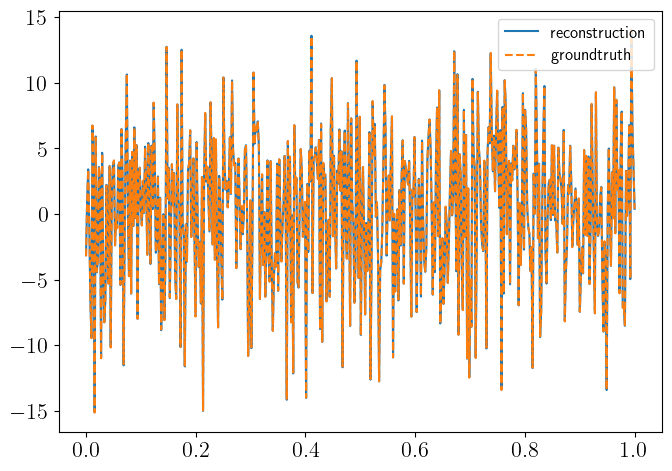

|u-u_gt|^2:            43.69879
|A(u)-f|^2:            49.00976



In [30]:
metrics = Metrics()
itnet.eval()
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    reconstruction = itnet(noisy_measurement.unsqueeze(1))[:,0]
    metrics.update(groundtruth, noisy_measurement, reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, reconstruction.shape[1]), reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/itnet.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(reconstruction).shape[1]), A(reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)

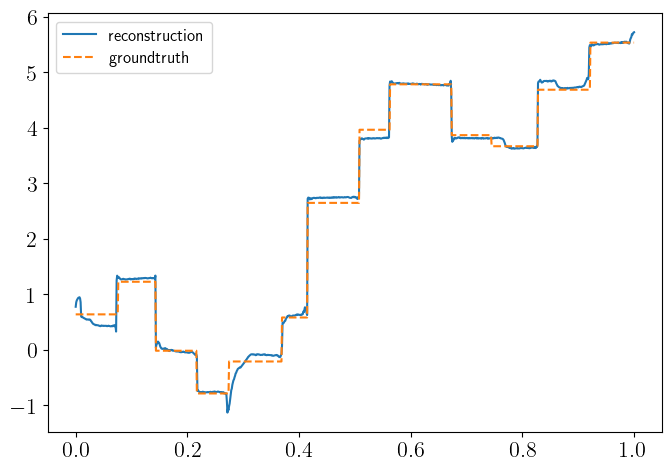

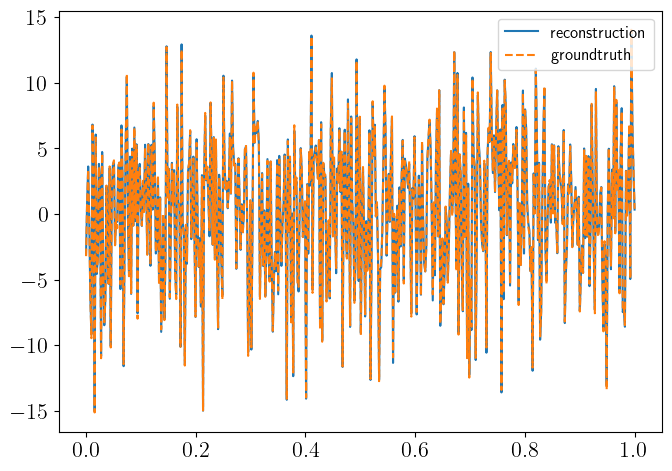

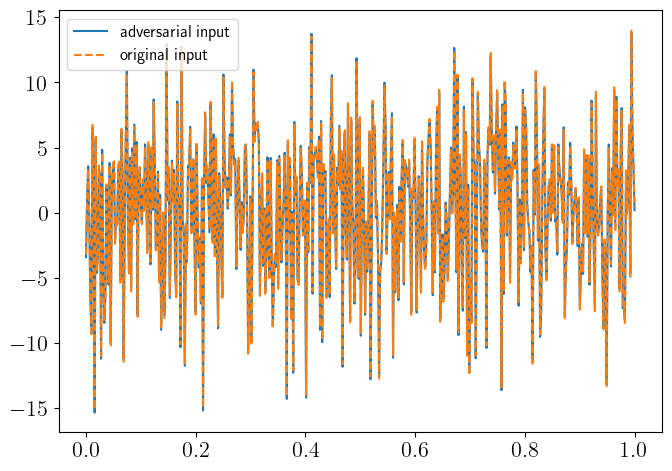

|u-u_gt|^2:            43.69879
|A(u)-f|^2:            49.00976
|u_adv-u_gt|^2:      3017.28377
|u-u_adv|^2:         2654.18911
|A(u_adv)-f_adv|^2:  3187.16389
|A(u)-A(u_adv)|^2:   2581.17898
|D(u)-D(u_adv)|^2:    628.12396
|f-f_adv|^2:         2621.44000


In [31]:
metrics = Metrics()
for i, (noisy_measurement, groundtruth) in enumerate(test_dataloader):
    noisy_measurement, groundtruth = noisy_measurement.to(torch.get_default_dtype()), groundtruth.to(torch.get_default_dtype())
    noisy_measurement, groundtruth = noisy_measurement.to(DEVICE), groundtruth.to(DEVICE)
    original_reconstruction = itnet(noisy_measurement.unsqueeze(1))[:,0]
    adversarial_measurement = noisy_measurement.clone()
    adversarial_measurement.requires_grad = True
    reconstruction = original_reconstruction.clone()
    for _ in range(ADV_ITERATIONS):
        with torch.enable_grad():
            reconstruction = itnet(adversarial_measurement.unsqueeze(1))[:,0]
            loss = F.mse_loss(reconstruction, groundtruth)
            loss.backward()
        adversarial_measurement = adversarial_measurement + ADV_LR*torch.sign(adversarial_measurement.grad)
        adversarial_measurement = noisy_measurement + project_ball(adversarial_measurement-noisy_measurement, ADV_EPSILON)
        adversarial_measurement.requires_grad = True
    adversarial_reconstruction = itnet(adversarial_measurement.unsqueeze(1))[:,0]
    metrics.update(groundtruth, noisy_measurement, original_reconstruction, adversarial_measurement, adversarial_reconstruction)
    if i == 0:
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, adversarial_reconstruction.shape[1]), adversarial_reconstruction[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, groundtruth.shape[1]), groundtruth[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.savefig("figures/itnet_adv.pdf")
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, A(adversarial_reconstruction).shape[1]), A(adversarial_reconstruction)[B].detach().to("cpu").numpy(), label="reconstruction")
        plt.plot(torch.linspace(0.0, 1.0, A(groundtruth).shape[1]), A(groundtruth)[B].detach().to("cpu").numpy(), "--", label="groundtruth")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(7,5))
        plt.plot(torch.linspace(0.0, 1.0, adversarial_measurement.shape[1]), adversarial_measurement[B].detach().to("cpu").numpy(), label="adversarial input")
        plt.plot(torch.linspace(0.0, 1.0, noisy_measurement.shape[1]), noisy_measurement[B].detach().to("cpu").numpy(), "--", label="original input")
        plt.legend(prop={"size": 12})
        plt.tight_layout()
        plt.show()
print(metrics)